### [LSTM/ML Inspo](https://github.com/emirhanai/Cryptocurrency-Prediction-with-Artificial-Intelligence)
Good 15 min video about LSTMs [here](https://www.youtube.com/watch?v=QciIcRxJvsM)

### [CRYPTO API Stuff](https://www.alphavantage.co/documentation/)

In [194]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras import layers

## Crypto API

In [195]:
def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'YOUR API KEY'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

COIN = 'BTC'
data = get_crypto_price(symbol = COIN, exchange = 'USD', start_date = '2020-01-01')
num_rows = len(data)
data

,open,high,low,close,volume
2020-01-01,7195.24,7255.00,7175.15,7200.85,16792.388165
2020-01-02,7200.77,7212.50,6924.74,6965.71,31951.483932
2020-01-03,6965.49,7405.00,6871.04,7344.96,68428.500451
2020-01-04,7345.00,7404.00,7272.21,7354.11,29987.974977
2020-01-05,7354.19,7495.00,7318.00,7358.75,38331.085604
...,...,...,...,...,...
2022-02-27,39116.73,39855.70,37000.00,37699.07,46229.447190
2022-02-28,37699.08,44225.84,37450.17,43160.00,73945.638580
2022-03-01,43160.00,44949.00,42809.98,44421.20,61743.098730
2022-03-02,44421.20,45400.00,43334.09,43892.98,57782.650810


In [118]:
ls= [0,1,2,3,4]
ls[-1:]

[4]

## Data Prep

In [52]:
# data to train on from API call
aim = 'close'

In [151]:
# take last TEST_SIZE data points (rows) for testing model, the first 1-TEST_SIZE is for training 
TRAIN_SIZE = 0.8
train_data = data.iloc[:int(TRAIN_SIZE*num_rows)]
test_data = data.iloc[int(TRAIN_SIZE*num_rows):]

In [196]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('XRP/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

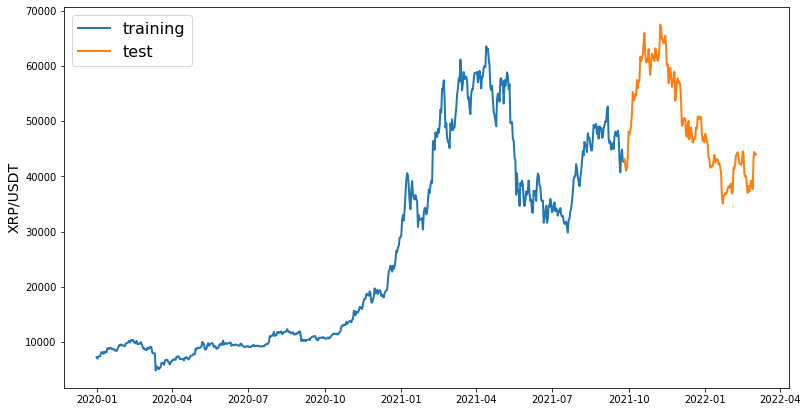

In [199]:
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

In [202]:
# data is normalized when it is placed into dataset
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [203]:
def extract_window_data(continuous, window_len=5, zero_base=True):
    # copies data from continuous(dict) to window_data(nparray)
    
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        else:
            tmp = normalise_min_max(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


## Build the Model

In [204]:
def build_lstm_model(input_data, output_size, neurons, activ_func='tanh',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, 
                   input_shape=(input_data.shape[1], input_data.shape[2]) ,
                   recurrent_activation="sigmoid",))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [209]:
np.random.seed(245)
window_len = 5
test_size = 1 - TRAIN_SIZE
zero_base = True
lstm_neurons = 50
epochs = 30
batch_size = 32
loss = 'mse'
dropout = 0.3
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [208]:
model = build_lstm_model(
    X_train, 
    output_size=1, 
    neurons=lstm_neurons, 
    dropout=dropout, 
    loss=loss,
    optimizer=optimizer)

modelfit = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1, 
    shuffle=True)

Epoch 1/40
20/20 [==============================] - 2s 28ms/step - loss: 0.0097 - val_loss: 0.0041
Epoch 2/40
20/20 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 3/40
20/20 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 4/40
20/20 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 5/40
20/20 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 6/40
20/20 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 7/40
20/20 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 8/40
20/20 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 9/40
20/20 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 10/40
20/20 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 11/40
20/

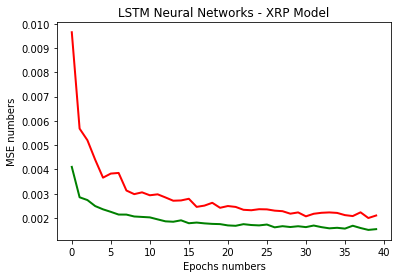

In [210]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

## Results

In [184]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.027889596444782616

In [185]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.0014837277476029524

In [186]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

75.21652265412237

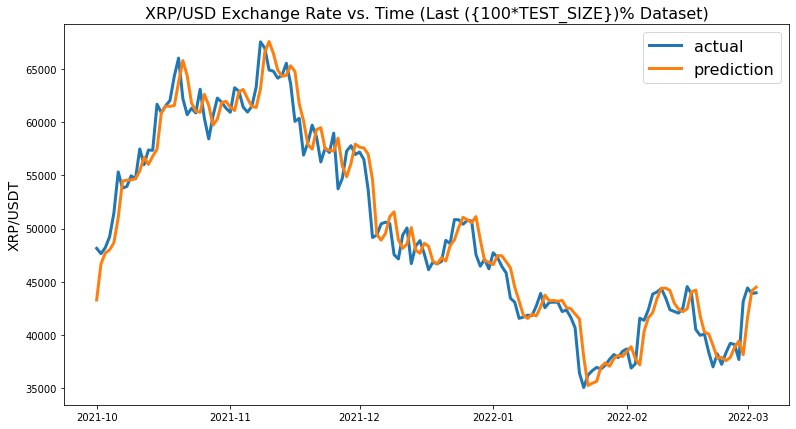

In [187]:
plot_preds = test_data[aim].values[:-window_len] * (preds + 1)
plot_preds = pd.Series(index=targets.index, data=plot_preds)
line_plot(targets, 
          plot_preds, 
          'actual', 
          'prediction', 
          lw=3, 
          title='XRP/USD Exchange Rate vs. Time (Last ({100*TEST_SIZE})% Dataset)')